In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from sklearn.datasets import make_moons

In [63]:
X, y = make_moons(n_samples=250, noise=0.2, random_state=42)

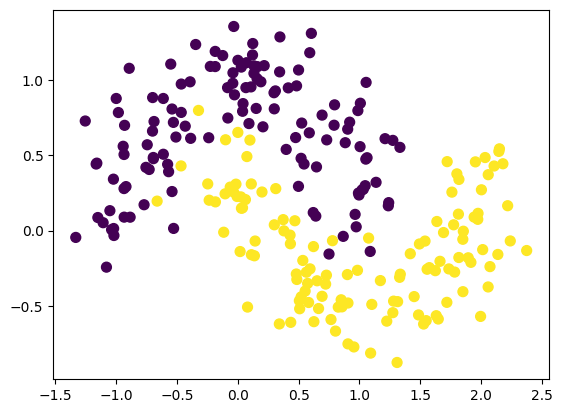

In [64]:
plt.scatter(X[:,0], X[:,1], c=y, s=50)
plt.show()

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [66]:
class WI_random_small(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=2),
            nn.Sigmoid(),
            nn.Linear(in_features=2, out_features=2),
            nn.Sigmoid(),
            nn.Linear(in_features=2, out_features=2),
            nn.Sigmoid(),
            nn.Linear(in_features=2, out_features=2),
            nn.Sigmoid(),
            nn.Linear(in_features=2, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.linear_stack(x)

model = WI_random_small().to(device)

In [67]:
model

WI_random_small(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=2, out_features=2, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=2, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [68]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[0.6245, 0.2898],
                      [0.2321, 0.0071]])),
             ('linear_stack.0.bias', tensor([-0.5084,  0.4796])),
             ('linear_stack.2.weight',
              tensor([[-0.1839, -0.1700],
                      [-0.3345,  0.3491]])),
             ('linear_stack.2.bias', tensor([-0.2855,  0.0104])),
             ('linear_stack.4.weight',
              tensor([[-0.2737, -0.0471],
                      [ 0.6192,  0.3624]])),
             ('linear_stack.4.bias', tensor([-0.3960,  0.0967])),
             ('linear_stack.6.weight',
              tensor([[-0.2723, -0.1935],
                      [ 0.6529,  0.0384]])),
             ('linear_stack.6.bias', tensor([ 0.6891, -0.1121])),
             ('linear_stack.8.weight', tensor([[0.1375, 0.4767]])),
             ('linear_stack.8.bias', tensor([-0.1301]))])

In [69]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

27

In [70]:
# Given weights and biases
weights = [
    torch.tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]], dtype=torch.float32),  # fc1 weight
    torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5], dtype=torch.float32),                 # fc1 bias
    torch.tensor([[0.5], [0.5]], dtype=torch.float32),           # fc2 weight
    torch.tensor([0.5], dtype=torch.float32)                      # fc2 bias
]

In [71]:
with torch.no_grad():
    model.linear_stack[0].weight.copy_(model.linear_stack[0].weight * (0.001))  
    model.linear_stack[0].bias.copy_(model.linear_stack[0].bias * (0.001))

    model.linear_stack[2].weight.copy_(model.linear_stack[2].weight * 0.001)  
    model.linear_stack[2].bias.copy_(model.linear_stack[2].bias * 0.001)

    model.linear_stack[4].weight.copy_(model.linear_stack[4].weight * 0.001)  
    model.linear_stack[4].bias.copy_(model.linear_stack[4].bias * 0.001)
    
    model.linear_stack[6].weight.copy_(model.linear_stack[6].weight * 0.001)
    model.linear_stack[6].bias.copy_(model.linear_stack[6].bias * 0.001)

In [72]:
model.linear_stack[0].weight * (model.linear_stack[0].weight * 0.001)

tensor([[3.8995e-10, 8.3998e-11],
        [5.3875e-11, 4.9969e-14]], grad_fn=<MulBackward0>)

In [73]:
## 0.000065592 = 6.5592e-05

In [74]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[6.2446e-04, 2.8982e-04],
                      [2.3211e-04, 7.0689e-06]])),
             ('linear_stack.0.bias', tensor([-0.0005,  0.0005])),
             ('linear_stack.2.weight',
              tensor([[-0.0002, -0.0002],
                      [-0.0003,  0.0003]])),
             ('linear_stack.2.bias', tensor([-2.8555e-04,  1.0382e-05])),
             ('linear_stack.4.weight',
              tensor([[-2.7369e-04, -4.7117e-05],
                      [ 6.1918e-04,  3.6239e-04]])),
             ('linear_stack.4.bias', tensor([-3.9596e-04,  9.6698e-05])),
             ('linear_stack.6.weight',
              tensor([[-2.7235e-04, -1.9353e-04],
                      [ 6.5294e-04,  3.8410e-05]])),
             ('linear_stack.6.bias', tensor([ 0.0007, -0.0001])),
             ('linear_stack.8.weight', tensor([[0.1375, 0.4767]])),
             ('linear_stack.8.bias', tensor([-0.1301]))])

In [75]:
# loss_fc and optimizer
loss_fc = nn.BCELoss() 

optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.001)

In [76]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [77]:
# building a training and evaluation loop

epochs = 100

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y)


# lets print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 0.69706
Epoch: 10 | Loss: 0.69611
Epoch: 20 | Loss: 0.69533
Epoch: 30 | Loss: 0.69470
Epoch: 40 | Loss: 0.69421
Epoch: 50 | Loss: 0.69386
Epoch: 60 | Loss: 0.69360
Epoch: 70 | Loss: 0.69343
Epoch: 80 | Loss: 0.69332
Epoch: 90 | Loss: 0.69324


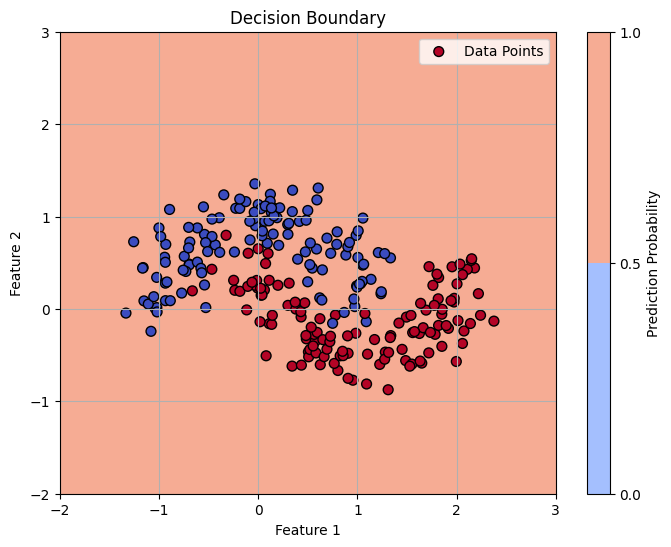

In [78]:
# 1. Generate a grid of points
x1_range = np.linspace(-2.0, 3.0, 200)
x2_range = np.linspace(-2.0, 3.0, 200)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 2. Predict probabilities for the grid points
with torch.no_grad():
    grid_preds = model(grid_tensor).numpy()

# 3. Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, grid_preds.reshape(x1_grid.shape), levels=[0, 0.5, 1], alpha=0.8, cmap='coolwarm')
plt.colorbar(label='Prediction Probability')

# 4. Overlay the data points
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', cmap='coolwarm', s=50, label='Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.legend()
plt.grid()
plt.show()

In [79]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[-0.1137,  0.1120],
                      [-0.1143,  0.1120]])),
             ('linear_stack.0.bias', tensor([0.0565, 0.0576])),
             ('linear_stack.2.weight',
              tensor([[0.1266, 0.1267],
                      [0.1265, 0.1272]])),
             ('linear_stack.2.bias', tensor([0.1142, 0.1144])),
             ('linear_stack.4.weight',
              tensor([[0.1026, 0.1028],
                      [0.1057, 0.1055]])),
             ('linear_stack.4.bias', tensor([0.0996, 0.1025])),
             ('linear_stack.6.weight',
              tensor([[-0.0626, -0.0626],
                      [-0.0686, -0.0692]])),
             ('linear_stack.6.bias', tensor([-0.0605, -0.0679])),
             ('linear_stack.8.weight', tensor([[0.0684, 0.4076]])),
             ('linear_stack.8.bias', tensor([-0.2003]))])

# to check for the relu
https://www.deeplearning.ai/ai-notes/initialization/index.html

In [84]:
"https://github.com/ajstyle007/Deep-Learning/blob/main/8.%20Weight%20initialization/relu_with_too_small_weights.png"

'https://github.com/ajstyle007/Deep-Learning/blob/main/8.%20Weight%20initialization/relu_with_too_small_weights.png'

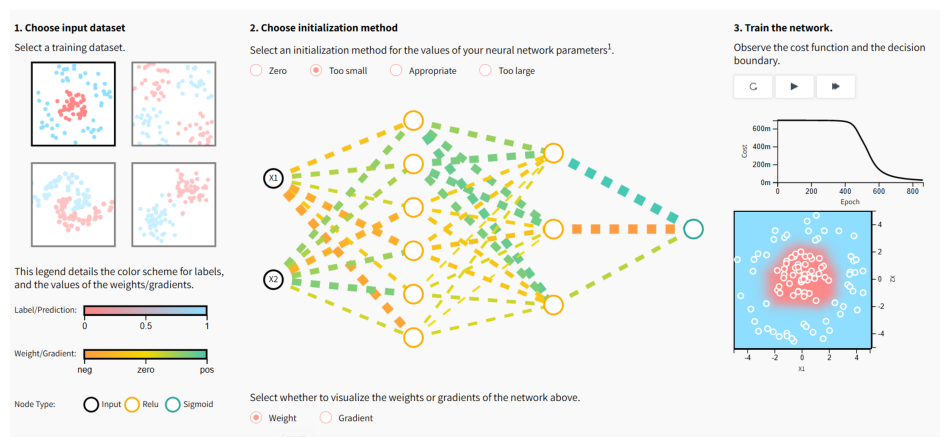

In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image
image = mpimg.imread('relu_with_too_small_weights.png')

plt.figure(figsize=(12, 6))
# Display the image
plt.imshow(image,)
plt.axis('off')  # Remove axes
plt.show()

- as we can see in above picture the relu takes more epochs for convergence means slow trainig

### in case of very large values 

- in case of tanh and sigmoid the training will be slow and in worst case senarios the vanishing gradient problem coold happen
- and in case of Relu the gradient becomes unstable

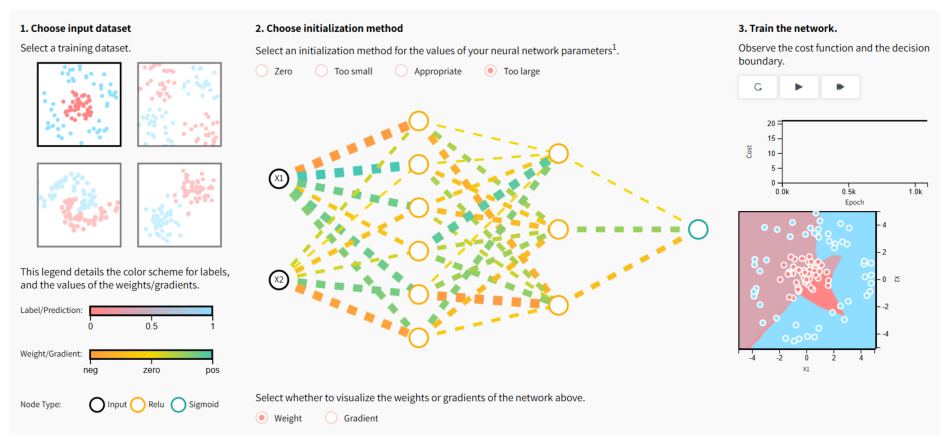

In [92]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image
image = mpimg.imread('relu_with_too_large_weights.png')
plt.figure(figsize=(12, 6))
# Display the image
plt.imshow(image,)
plt.axis('off')  # Remove axes
plt.show()